# Step-by-Step Implementation of Positional Encoding
### Step 1: Understand the Formula
 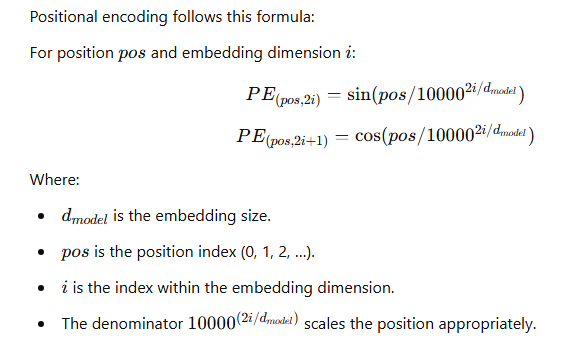
# Step 2: Define a Positional Encoding Layer

In [1]:
import tensorflow as tf
import numpy as np

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.d_model = d_model
        self.positional_encoding = self.compute_positional_encoding()

    def compute_positional_encoding(self):
        positions = np.arange(self.max_len)[:, np.newaxis]  # Shape: (max_len, 1)
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-np.log(10000.0) / self.d_model))  # Shape: (d_model/2,)
        
        pe = np.zeros((self.max_len, self.d_model))  # Shape: (max_len, d_model)
        pe[:, 0::2] = np.sin(positions * div_term)  # Apply sine to even indices
        pe[:, 1::2] = np.cos(positions * div_term)  # Apply cosine to odd indices

        return tf.convert_to_tensor(pe, dtype=tf.float32)

    def call(self, inputs):
        batch_size, seq_len, d_model = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2]
        return inputs + self.positional_encoding[:seq_len, :]



# Step 1: Tokenization

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Define tokenization parameters
vocab_size = 20000  # Maximum vocabulary size
sequence_length = 64  # Max length of each input sentence

# Tokenizer for source language (English)
source_vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)

# Tokenizer for target language (Telugu)
target_vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)

# Sample text data
source_texts = ["Hello, how are you?", "I love machine learning."]
target_texts = ["హలో, మీరు ఎలా ఉన్నారు?", "నేను యంత్ర అభ్యాసాన్ని ప్రేమిస్తున్నాను."]

# Adapt tokenizers to the dataset
source_vectorizer.adapt(source_texts)
target_vectorizer.adapt(target_texts)

# Example tokenization
print("Tokenized Source:", source_vectorizer(source_texts))
print("Tokenized Target:", target_vectorizer(target_texts))


Tokenized Source: tf.Tensor(
[[8 7 9 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [6 4 3 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(2, 64), dtype=int64)
Tokenized Target: tf.Tensor(
[[2 4 7 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [6 3 9 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(2, 64), dtype=int64)


# Step 2: Embedding Layer
### Why We Use an Embedding Layer:
* Converts discrete token IDs into dense, meaningful vectors.
* mask_zero=True ensures the Transformer ignores padding tokens.


In [2]:
from tensorflow.keras.layers import Embedding

embedding_dim = 128  # Dimension of word embeddings

# Define embedding layers
source_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)
target_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)

# Example usage
source_tokens = source_vectorizer(source_texts)  # Convert text to tokens
embedded_source = source_embedding(source_tokens)  # Convert tokens to dense vectors

print("Embedded Source Shape:", embedded_source.shape)  # (batch_size, sequence_length, embedding_dim)


Embedded Source Shape: (2, 64, 128)


# Step 3: Positional Encoding
* Transformers don’t have recurrence (like RNNs), so we need positional encoding to indicate word order.
* ✅ What This Does:
* Adds sinusoidal positional information to embeddings.
* Ensures word order is captured by the model

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len

        # Compute positional encoding
        positions = np.arange(max_len)[:, np.newaxis]  # (max_len, 1)
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))  # (d_model/2,)

        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(positions * div_term)  # Apply sine to even indices
        pe[:, 1::2] = np.cos(positions * div_term)  # Apply cosine to odd indices

        self.positional_encoding = tf.constant(pe, dtype=tf.float32)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.positional_encoding[:seq_len, :]

    def compute_mask(self, inputs, mask=None):
        return mask  # Preserve the mask


In [4]:
# Apply positional encoding to embeddings
pos_encoding = PositionalEncoding(sequence_length, embedding_dim)

# Example usage
embedded_source_with_pe = pos_encoding(embedded_source)

print("Shape after Positional Encoding:", embedded_source_with_pe.shape)  # (batch_size, sequence_length, embedding_dim)

Shape after Positional Encoding: (2, 64, 128)


# Step 4: Transformer Encoder
* Now that we have tokenized input, embeddings, and positional encoding, let’s build the Transformer Encoder.
* ✅ What This Does:
* Applies multi-head self-attention to the input.
* Passes the result through a feed-forward network.
* Uses Layer Normalization & Residual Connections to stabilize training.

In [5]:
import tensorflow as tf

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()

        # Multi-head Self-Attention
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)

        # Feed-Forward Network (Dense layers)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),  # Expand dimension
            tf.keras.layers.Dense(d_model)  # Reduce back to d_model
        ])

        # Layer Normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dropout layers
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        # 1️⃣ Self-Attention Layer (with residual connection)
        attn_output = self.mha(x, x, x, attention_mask=mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Add & Normalize

        # 2️⃣ Feed-Forward Network (with residual connection)
        ffn_output = self.ffn(out1)  # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Normalize

        return out2  # (batch_size, seq_len, d_model)


# Recap of What We Have Done So Far 🚀
* 1️⃣ Tokenization: Convert text into numbers using TextVectorization.
* 2️⃣ Embedding Layer: Map tokens to dense vectors (Embedding).
* 3️⃣ Positional Encoding: Add position information (PositionalEncoding).
* 4️⃣ Transformer Encoder: Build a single encoder block (Multi-Head Attention + Feed Forward).

* Now that we have the Encoder, the next step is stacking multiple Encoder layers before moving to the Decoder.

# 1️⃣ What Does Stacking Encoders Mean?
* A Transformer encoder consists of multiple identical encoder layers stacked on top of each other.
* Each layer processes the input and passes the output to the next encoder in the stack.

* 📝 Key Idea:
* Each encoder layer learns progressively more abstract features about the input sentence.

* 📌 Example:

* Lower layers capture word-level dependencies.
* Higher layers capture sentence-level meaning.
* 2️⃣ Code: Stacking Encoders in TensorFlow/Keras
* Now, let's build the full encoder stack using multiple layers.
# 3️⃣ How Does It Work?
* Token Embedding: Converts input tokens into dense vectors.
* Positional Encoding: Adds positional information to the embeddings.
* Dropout: Prevents overfitting.
* Stacked Encoder Layers: Each encoder layer refines the representation by passing data through multi-head attention and feed-forward networks.
* 📌 Each layer gets the same input shape, processes it, and passes it forward.

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, max_len, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        # Token Embedding + Positional Encoding
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
        self.pos_encoding = PositionalEncoding(max_len, d_model)

        # Stack multiple encoder layers
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training=True, mask=None):  # ✅ Default keyword arguments
        seq_len = tf.shape(x)[1]
    
        # 1. Token Embedding
        x = self.embedding(x)  # Shape: (batch_size, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # Scale embeddings
    
        # 2. Add Positional Encoding
        x = self.pos_encoding(x)
    
        # 3. Apply Dropout
        x = self.dropout(x, training=training)
    
        # 4. Pass through multiple encoder layers (fix here)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)  # ✅ Fix
    
        return x  # Final encoder representation



In [7]:
num_layers = 6      # Number of encoder layers
d_model = 512       # Embedding dimension
num_heads = 8       # Multi-head attention heads
dff = 2048          # Feed-forward network size
vocab_size = 10000  # Vocabulary size
max_len = 100       # Maximum input length

encoder = TransformerEncoder(num_layers, d_model, num_heads, dff, vocab_size, max_len)

# Dummy input
sample_input = tf.random.uniform((2, 50), dtype=tf.int32, minval=0, maxval=200)  # (batch_size=2, seq_len=50)
mask = None  # Padding mask (to be defined properly)

output = encoder(sample_input, training=True, mask=mask)
print("Encoder Output Shape:", output.shape)


Encoder Output Shape: (2, 50, 512)


# Step 1: Implement a Single Decoder Layer
* Each decoder layer consists of:

* Masked Multi-Head Self-Attention (prevents looking ahead in sequences)
* Encoder-Decoder Attention (allows the decoder to focus on encoder outputs)
* Feed-Forward Network
* Residual connections & Layer Normalization

In [8]:
import tensorflow as tf

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        # 1️⃣ Self-Attention (with causal masking)
        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)

        # 2️⃣ Encoder-Decoder Cross Attention
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)

        # 3️⃣ Feed-Forward Network
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),  # Expand dimension
            tf.keras.layers.Dense(d_model)  # Reduce back to d_model
        ])

        # Layer Normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dropout layers
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, padding_mask):
        # 1️⃣ Self-Attention with **causal masking applied automatically**
        attn1 = self.mha1(x, x, x, use_causal_mask=True, training=training)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)  # Add & Normalize

        # 2️⃣ Encoder-Decoder Cross Attention (with padding mask)
        attn2 = self.mha2(out1, enc_output, enc_output, attention_mask=padding_mask, training=training)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)  # Add & Normalize

        # 3️⃣ Feed-Forward Network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)  # Add & Normalize

        return out3  # (batch_size, target_seq_len, d_model)


# Step 2: Implement the Full Transformer Decoder
* The TransformerDecoder stacks multiple DecoderLayer layers.

In [9]:
import tensorflow as tf

class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, max_len, dropout_rate=0.1):
        super(TransformerDecoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        # Token Embedding + Positional Encoding
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model, mask_zero=True)
        self.pos_encoding = PositionalEncoding(max_len, d_model)

        # Stack multiple decoder layers
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training=True, padding_mask=None):  # ✅ Ensure training is keyword argument
        seq_len = tf.shape(x)[1]

        # 1️⃣ Token Embedding
        x = self.embedding(x)  # Shape: (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # Scale embeddings

        # 2️⃣ Add Positional Encoding
        x = self.pos_encoding(x)

        # 3️⃣ Apply Dropout
        x = self.dropout(x, training=training)

        # 4️⃣ Pass through multiple decoder layers
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training=training, padding_mask=padding_mask)  # ✅ Fix

        return x  # (batch_size, target_seq_len, d_model)


In [10]:
num_layers = 6        # Number of decoder layers
d_model = 512         # Embedding dimension
num_heads = 8         # Multi-head attention heads
dff = 2048            # Feed-forward network size
target_vocab_size = 10000  # Vocabulary size
max_len = 100         # Maximum target sequence length

decoder = TransformerDecoder(num_layers, d_model, num_heads, dff, target_vocab_size, max_len)

# Dummy inputs
target_input = tf.random.uniform((2, 50), dtype=tf.int32, minval=0, maxval=200)  # (batch_size=2, seq_len=50)
encoder_output = tf.random.uniform((2, 50, d_model))  # Encoder output
padding_mask = None  # (Normally, this would be generated based on padding tokens)

decoder_output = decoder(target_input, encoder_output, training=True, padding_mask=padding_mask)
print("Decoder Output Shape:", decoder_output.shape)  # Expected: (batch_size, target_seq_len, d_model)


Decoder Output Shape: (2, 50, 512)


# Full Transformer Model

In [11]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, target_vocab_size, max_len, dropout_rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, dff,
                                          input_vocab_size, max_len, dropout_rate)
        self.decoder = TransformerDecoder(num_layers, d_model, num_heads, dff,
                                          target_vocab_size, max_len, dropout_rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training=True):
        source_input, target_input = inputs
        # Create padding mask based on source tokens (assuming 0 is the padding token)
        padding_mask = self.create_padding_mask(source_input)
        enc_output = self.encoder(source_input, training=training, mask=padding_mask)
        # Note: We rely on the decoder’s internal causal mask via use_causal_mask=True.
        dec_output = self.decoder(target_input, enc_output, training=training, padding_mask=padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output  # (batch_size, target_seq_len, target_vocab_size)

    def create_padding_mask(self, seq):
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


* You're asking about a common way to create a padding mask in TensorFlow. Let's break down the create_padding_mask function step by step:

* Python

*def create_padding_mask(self, seq):
*     mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
*     return mask[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
* 1. tf.math.equal(seq, 0):

* This part checks for equality between each element in the input sequence seq and the value 0. Remember, 0 is conventionally used as the padding token.
* The result is a boolean tensor. True indicates a padding token (where the value is 0), and False indicates a real token.
* 2. tf.cast(..., tf.float32):

* The boolean tensor is then cast to a float32 tensor. True becomes 1.0, and False becomes 0.0. This is important because the attention mechanism usually works with floating-point numbers.
* 3. mask[:, tf.newaxis, tf.newaxis, :]:

* This is the crucial part that reshapes the mask. Let's say the original mask has a shape of (batch_size, seq_len). This line adds two new dimensions:
* tf.newaxis effectively inserts a new dimension of size 1.
* The resulting shape becomes (batch_size, 1, 1, seq_len).
* Why this reshaping?

* The reason for this specific reshaping is often related to how attention mechanisms are implemented, especially in Transformer models.  The attention mechanism often involves broadcasting the mask during calculations.  The (1, 1) in the middle dimensions are there to facilitate this broadcasting.

* Batch Size: The first dimension (batch_size) represents the number of sequences in the batch.
* Sequence Length: The last dimension (seq_len) represents the length of each sequence.
* The (1, 1) dimensions: These dimensions are added so that the mask can be easily broadcasted during the attention calculations, which often involve operations on tensors with shapes like (batch_size, num_heads, seq_len, seq_len) or similar. The (1,1) allows the mask to be applied correctly across different attention heads and positions within the sequences.
* How it's Used:

* The returned mask is then used in the attention mechanism.  Typically, the mask is applied to the attention weights before the softmax.  A large negative value (like -1e9) is added to the attention weights where the mask is 1 (padding tokens).  This forces the softmax to assign near-zero probability to the padding tokens, effectively excluding them from the attention calculation.

* In Summary:

* The create_padding_mask function takes a sequence of token IDs, identifies the padding tokens (usually represented by 0), and creates a mask that can be used to ignore these padding tokens during attention calculations.  The reshaping to (batch_size, 1, 1, seq_len) is a standard practice to make the mask compatible with the broadcasting operations commonly used in attention mechanisms.

# Model Compilation & Training

In [12]:
# Define hyperparameters
num_layers = 6
d_model = 512
num_heads = 8
dff = 2048
input_vocab_size = 10000
target_vocab_size = 10000
max_len = 100

In [13]:
# Instantiate Transformer model
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, max_len)

In [14]:
# Define loss function (SparseCategoricalCrossentropy)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [15]:
# Define optimizer with an exponential decay learning rate schedule
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=4000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [16]:
# Compile the model
transformer.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])


# Dummy Data for Training

In [17]:
# Create dummy data (replace with your real dataset)
dummy_source = tf.random.uniform((64, 100), dtype=tf.int32, minval=0, maxval=200)
dummy_target = tf.random.uniform((64, 100), dtype=tf.int32, minval=0, maxval=200)

In [18]:
# Train the model on dummy data
transformer.fit(x=[dummy_source, dummy_target],
                y=dummy_target,
                batch_size=32,
                epochs=10)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 210s 29s/step - accuracy: 0.0041 - loss: 9.1026   
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 28s/step - accuracy: 0.0434 - loss: 8.5828
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 29s/step - accuracy: 0.2507 - loss: 8.1944
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 29s/step - accuracy: 0.5382 - loss: 7.8035
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 28s/step - accuracy: 0.8691 - loss: 7.3947
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 28s/step - accuracy: 0.9651 - loss: 6.9866
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 30s/step - accuracy: 0.9945 - loss: 6.6045
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 29s/step - accuracy: 0.9990 - loss: 6.2338
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 27s/step - accuracy: 0.9998 - loss: 5.8834
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 28s/step - accuracy: 1.0000 - loss: 5.5414


In [19]:
#!pip install nltk
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


In [20]:
import numpy as np

def calculate_bleu_score(model, dataset, source_vectorizer, target_vectorizer, num_samples=10):
    """
    Evaluate Transformer model on a dataset using BLEU score.

    Args:
    - model: Trained Transformer model
    - dataset: Preprocessed dataset (`tf.data.Dataset`)
    - source_vectorizer: Vectorizer for English (source)
    - target_vectorizer: Vectorizer for Telugu (target)
    - num_samples: Number of sentences to evaluate
    
    Returns:
    - Average BLEU score
    """
    total_bleu = 0
    smooth_fn = SmoothingFunction().method1  # Smoothing for better BLEU scores

    for i, (source, target) in enumerate(dataset.take(num_samples)):  
        # Convert tokenized input to string
        source_text = " ".join(source_vectorizer.get_vocabulary()[t] for t in source.numpy()[0] if t != 0)
        target_text = " ".join(target_vectorizer.get_vocabulary()[t] for t in target.numpy()[0] if t != 0)

        # Generate prediction
        predicted_tokens = model.predict(tf.expand_dims(source, axis=0))  # (1, seq_len, vocab_size)
        predicted_tokens = np.argmax(predicted_tokens, axis=-1)  # Convert logits to token indices

        # Convert predicted tokens back to text
        predicted_text = " ".join(target_vectorizer.get_vocabulary()[t] for t in predicted_tokens[0] if t != 0)

        # Compute BLEU score
        reference = [target_text.split()]  # BLEU expects list of reference lists
        candidate = predicted_text.split()
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smooth_fn)

        print(f"\nExample {i+1}:")
        print(f"Source: {source_text}")
        print(f"Target: {target_text}")
        print(f"Predicted: {predicted_text}")
        print(f"BLEU Score: {bleu_score:.4f}")

        total_bleu += bleu_score

    avg_bleu = total_bleu / num_samples
    print(f"\nAverage BLEU Score: {avg_bleu:.4f}")
    return avg_bleu


In [21]:
average_bleu = calculate_bleu_score(transformer, dataset=test_dataset, 
                                    source_vectorizer=source_vectorizer, 
                                    target_vectorizer=target_vectorizer)


NameError: name 'test_dataset' is not defined

In [22]:
import tensorflow as tf
import numpy as np

def translate_sentence(model, sentence, source_vectorizer, target_vectorizer, max_len=100):
    """
    Translates a single source sentence into the target language using the trained Transformer model.
    
    Args:
        model: The trained Transformer model.
        sentence: A raw source sentence (string).
        source_vectorizer: A TextVectorization layer fitted on source language texts.
        target_vectorizer: A TextVectorization layer fitted on target language texts.
        max_len: Maximum length of the generated sequence.
        
    Returns:
        predicted_sentence: The translated sentence as a string.
    """
    # --- 1. Preprocess the source sentence ---
    # The vectorizer converts the sentence to token indices (batch shape: (1, sequence_length))
    source_tokens = source_vectorizer([sentence])
    
    # --- 2. Prepare the initial target sequence ---
    # Here we assume your target vocabulary contains special tokens '<start>' and '<end>'.
    # If you haven't added them, you can designate indices (e.g., 1 for start, 2 for end)
    vocab = target_vectorizer.get_vocabulary()
    try:
        start_token = vocab.index('<start>')
    except ValueError:
        # Fallback if not present; adjust as needed.
        start_token = 1  
    try:
        end_token = vocab.index('<end>')
    except ValueError:
        # Fallback if not present; adjust as needed.
        end_token = 2  
    
    # Initialize the target sequence with the start token
    output_tokens = [start_token]
    
    # --- 3. Iteratively generate the output tokens ---
    for i in range(max_len):
        # Prepare target input (shape: (1, current_sequence_length))
        target_input = tf.expand_dims(output_tokens, axis=0)
        
        # Get predictions from the model (shape: (1, target_seq_len, target_vocab_size))
        predictions = model([source_tokens, target_input], training=False)
        
        # Select the last token's logits and take argmax to get the next token id
        next_token_logits = predictions[0, -1, :]
        predicted_id = tf.argmax(next_token_logits).numpy()
        
        # Append the predicted token to the sequence
        output_tokens.append(int(predicted_id))
        
        # If the end token is generated, stop the generation loop
        if predicted_id == end_token:
            break

    # --- 4. Convert token indices back to words ---
    # Remove the start token before converting (optional, based on your needs)
    predicted_tokens = output_tokens[1:]
    
    # Convert tokens to words using the target vocabulary.
    predicted_words = [vocab[token] for token in predicted_tokens if token < len(vocab)]
    
    # Optionally, remove tokens that appear after the end token (if any remain)
    if '<end>' in predicted_words:
        end_index = predicted_words.index('<end>')
        predicted_words = predicted_words[:end_index]
    
    predicted_sentence = " ".join(predicted_words)
    return predicted_sentence

# --- Example usage ---
source_sentence = "Hello, how are you?"
translated_sentence = translate_sentence(transformer, source_sentence, source_vectorizer, target_vectorizer)
print("Source:", source_sentence)
print("Translation:", translated_sentence)


C:\Users\dushy\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Source: Hello, how are you?
Translation: [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
